## Dataset 2: Steam Games (Implicit Feedback)

### 🔹 Setup Summary
- **Data type:** Implicit feedback (playtime or ownership)
- **Filtering:** only focus on play 
- **Spliting of data:** Hides exactly 5 items per user for test data
- **Models:** User-Based Collaborative Filtering (User–User KNN), Item-Based Collaborative Filtering (Item–Item KNN)
- **Similarity Metrics Tested:** cosine similarity, pearson correlation and euclidean distance（only user based CF)
- **Parameters Tested:** [e.g., k = 5 to 30, steps = 3】
- **Evaluation Metrics:** RMSE, MAE (for prediction accuracy), Precision and Recall


1. Data Prepocessing and Analyzation

In [2]:
# import library and read dataset
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt

# Load and preprocess Steam dataset
df = pd.read_csv("steam-200k.csv",names=['user_id', 'game_name', 'behavior', 'hours', 'other'])
df.head(5)

,user_id,game_name,behavior,hours,other
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


In [3]:
# Apply filtering 
# Filter only play behaviors (remove purchases)
df_play = df[df['behavior'] == 'play'].copy()

#drop column "other"
df_play = df_play.drop("other",axis = 1)
df_play.head(5)

,user_id,game_name,behavior,hours
1,151603712,The Elder Scrolls V Skyrim,play,273.0
3,151603712,Fallout 4,play,87.0
5,151603712,Spore,play,14.9
7,151603712,Fallout New Vegas,play,12.1
9,151603712,Left 4 Dead 2,play,8.9


In [4]:
df['hours'].describe(percentiles=[.5, .9, .95, .99])

count    200000.000000
mean         17.874384
std         138.056952
min           0.100000
50%           1.000000
90%          15.400000
95%          46.000000
99%         364.000000
max       11754.000000
Name: hours, dtype: float64

In [5]:
    # Cap hours and normalize to 0–5 scale
clip_hours=100
df_play['hours'] = df_play['hours'].clip(upper=clip_hours)
df_play['rating'] = (df_play['hours'] / clip_hours) * 5
df_play.head(5)

,user_id,game_name,behavior,hours,rating
1,151603712,The Elder Scrolls V Skyrim,play,100.0,5.000
3,151603712,Fallout 4,play,87.0,4.350
5,151603712,Spore,play,14.9,0.745
7,151603712,Fallout New Vegas,play,12.1,0.605
9,151603712,Left 4 Dead 2,play,8.9,0.445


In [6]:
# Create user-game matrix
user_game_matrix = df_play.pivot_table(
    index="user_id", 
    columns="game_name", 
    values="rating", 
    aggfunc="mean",
    fill_value=0
)
print(f"User-Game Matrix shape: {user_game_matrix.shape}")
print(f"Number of users: {user_game_matrix.shape[0]}")
print(f"Number of games: {user_game_matrix.shape[1]}")
print(f"sparsity: {(1 - np.count_nonzero(user_game_matrix)/user_game_matrix.size):.3f}")
user_game_matrix.head(5)

User-Game Matrix shape: (11350, 3600)
Number of users: 11350
Number of games: 3600
sparsity: 0.998


game_name,007 Legends,0RBITALIS,1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),10 Second Ninja,"10,000,000",100% Orange Juice,1000 Amps,12 Labours of Hercules,12 Labours of Hercules II The Cretan Bull,12 Labours of Hercules III Girl Power,...,rFactor,rFactor 2,realMyst,realMyst Masterpiece Edition,resident evil 4 / biohazard 4,rymdkapsel,sZone-Online,the static speaks my name,theHunter,theHunter Primal
user_id,,,,,,,,,,,,,,,,,,,,,
5250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
144736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
181212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


USER HOURS DISTRIBUTION ANALYSIS:
Total users: 11350
Total games: 3600
Matrix sparsity: 99.8%
Hours counts per user:
Minimum: 1
Average: 6.2
Median: 1.0
Maximum: 498

Users by rating count:
≥  1 Hours: 11350 users (100.0%)
≥  2 Hours: 4791 users ( 42.2%)
≥  3 Hours: 3466 users ( 30.5%)
≥  5 Hours: 2436 users ( 21.5%)
≥ 10 Hours: 1477 users ( 13.0%)
≥ 20 Hours:  800 users (  7.0%)


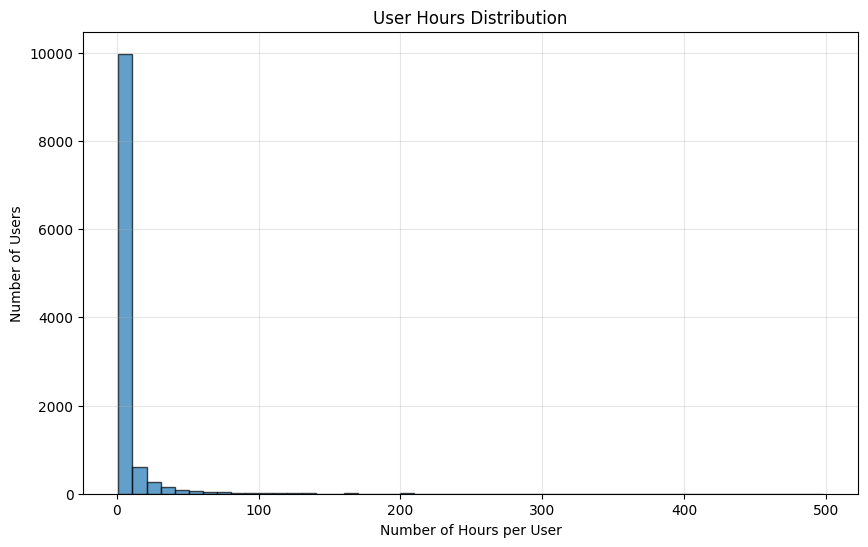

In [7]:
def analyze_user_rating_distribution(user_game_matrix):
    """
    Analyze how many hours each user has
    """
    user_game_matrix = user_game_matrix.applymap(lambda x: min(x, 100))  # Cap at 100 hours

    user_hours_counts = (user_game_matrix > 0).sum(axis=1)
    
    print("USER HOURS DISTRIBUTION ANALYSIS:")
    print("="*50)
    print(f"Total users: {len(user_hours_counts)}")
    print(f"Total games: {user_game_matrix.shape[1]}")
    print(f"Matrix sparsity: {(user_game_matrix == 0).sum().sum() / (user_game_matrix.shape[0] * user_game_matrix.shape[1]) * 100:.1f}%")
    
    print(f"Hours counts per user:")
    print(f"Minimum: {user_hours_counts.min()}")
    print(f"Average: {user_hours_counts.mean():.1f}")
    print(f"Median: {user_hours_counts.median()}")
    print(f"Maximum: {user_hours_counts.max()}")
    
    print(f"\nUsers by rating count:")
    for threshold in [1, 2, 3, 5, 10, 20]:
        count = (user_hours_counts >= threshold).sum()
        percentage = count / len(user_hours_counts) * 100
        print(f"≥ {threshold:2d} Hours: {count:4d} users ({percentage:5.1f}%)")
    
    # Plot distribution
    plt.figure(figsize=(10, 6))
    plt.hist(user_hours_counts, bins=50, edgecolor='black', alpha=0.7)
    plt.xlabel('Number of Hours per User')
    plt.ylabel('Number of Users')
    plt.title('User Hours Distribution')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return user_hours_counts

# Run the analysis
rating_counts = analyze_user_rating_distribution(user_game_matrix)
# Choose min rating = 2 (better representation) as our threshold

2. Collaborative Filtering

(a) User-based collaborative filtering

In [8]:
def user_based_collaborative_filtering(matrix, target_user, n_similar_users=10, similarity_metric='cosine'):
    """
    User-User Collaborative Filtering
    
    Parameters:
        matrix (DataFrame): user-item rating matrix
        target_user: user id (must exist in matrix)
        n_similar_users (int): number of neighbors
        similarity_metric (str): 'cosine', 'euclidean', 'pearson'
        
    Returns:
        recommendations (list of tuples): [(item, predicted_rating), ...] top 10
        predicted_ratings (dict): {item: predicted_rating, ...} for all items
    """
    if target_user not in matrix.index:
        return [], {}

    # 1️Mean-center per user
    matrix_centered = matrix.sub(matrix.mean(axis=1), axis=0).fillna(0)

    # 2️Compute similarity
    if similarity_metric == 'cosine':
        sim = cosine_similarity(matrix_centered)
    elif similarity_metric == 'euclidean':
        dist = euclidean_distances(matrix_centered)
        sim = 1 / (1 + dist)
    elif similarity_metric == 'pearson':
        sim = matrix_centered.T.corr().fillna(0).values
    else:
        raise ValueError("similarity_metric must be 'cosine', 'euclidean', or 'pearson'")

    sim_df = pd.DataFrame(sim, index=matrix.index, columns=matrix.index)

    # 3️Find top-n similar users
    similar_users = sim_df[target_user].sort_values(ascending=False)[1:n_similar_users+1]

    # 4️Weighted prediction
    weighted_sum = np.dot(similar_users.values, matrix_centered.loc[similar_users.index].values)
    norm_factor = similar_users.abs().sum()
    preds = weighted_sum / (norm_factor + 1e-9)

    # Convert to Series with proper index
    preds = pd.Series(preds, index=matrix.columns)

    # Add back user's mean
    preds += matrix.loc[target_user].mean()

    # Remove already played/rated items
    played = matrix.loc[target_user][matrix.loc[target_user] > 0].index
    preds = preds.drop(played, errors='ignore')

    # Top 10 recommendations
    recommendations = list(preds.sort_values(ascending=False).head(10).items())

    return recommendations, preds.to_dict()


In [9]:
# 2. Train-Test Split Function
def create_train_test_split(matrix, min_test_items=5):
    train = matrix.copy()
    test = {}

    for user in matrix.index:
        nonzero_games = matrix.loc[user][matrix.loc[user] > 0].index.tolist()
        if len(nonzero_games) > min_test_items:
            test_items = np.random.choice(nonzero_games, min_test_items, replace=False)
            test[user] = {g: matrix.loc[user, g] for g in test_items}
            train.loc[user, test_items] = 0
    return train, test

In [10]:
def filter_users_with_min_ratings(user_game_matrix, min_ratings):
# Removes unreliable users with very few ratings

# Improves recommendation quality (more data per user)

# Simpler and more standard approach

# Prevents the root cause rather than patching it
    """
    Keep only users with minimum number of ratings
    """
    user_rating_counts = (user_game_matrix > 0).sum(axis=1)
    filtered_users = user_rating_counts[user_rating_counts >= min_ratings].index
    filtered_matrix = user_game_matrix.loc[filtered_users]
    
    print(f"Filtered from {len(user_game_matrix)} to {len(filtered_matrix)} users")
    print(f"(Removed users with fewer than {min_ratings} ratings)")
    return filtered_matrix


In [11]:
# 3. Enhanced Evaluation Function
def robust_evaluate_recommendations(true_vals, pred_vals, threshold = 0.5):
    if len(true_vals) == 0:
        return {'rmse': np.nan, 'mae': np.nan, 'mse': np.nan, 'precision@k': np.nan,
                'recall@k': np.nan, 'valid_pr': False}

    rmse = np.sqrt(mean_squared_error(true_vals, pred_vals))
    mae = mean_absolute_error(true_vals, pred_vals)
    mse = mean_squared_error(true_vals, pred_vals)

    true_bin = (np.array(true_vals) >= threshold).astype(int)
    pred_bin = (np.array(pred_vals) >= threshold).astype(int)
    tp = np.sum(true_bin * pred_bin)
    precision = tp / (np.sum(pred_bin) + 1e-8)
    recall = tp / (np.sum(true_bin) + 1e-8)

    # Allow valid_pr even if len(true_vals) < 3
    return {'rmse': rmse, 'mae': mae, 'mse': mse,
            'precision@k': precision, 'recall@k': recall, 'valid_pr': True}



In [12]:
def find_optimal_k_auto(user_game_matrix, max_k=30, step=3, min_test_items=5, seed=42):
    """
    Finds optimal k for user-based CF and records evaluation metrics.
    Returns a results DataFrame and the best configuration.
    Safe version: no Mean of empty slice warnings, handles small overlaps.
    """
    import numpy as np
    import pandas as pd
    from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
    from sklearn.metrics import mean_squared_error, mean_absolute_error

    np.random.seed(seed)  # Reproducible results

    results = []
    filtered = user_game_matrix[user_game_matrix.sum(axis=1) > 0]
    train, test = create_train_test_split(filtered, min_test_items=min_test_items)

    # Keep only test users with at least one overlapping item
    test_users = [
        u for u, r in test.items()
        if len(r) >= 3 and len(set(r.keys()) & set(train.columns)) > 0
    ]

    # Mean-center training matrix
    matrix_centered = train.sub(train.mean(axis=1), axis=0).fillna(0)

    for metric in ['cosine', 'euclidean', 'pearson']:
        print(f"\nPrecomputing {metric} similarity...")
        if metric == 'cosine':
            sim = cosine_similarity(matrix_centered)
        elif metric == 'euclidean':
            dist = euclidean_distances(matrix_centered)
            sim = 1 / (1 + dist)
        else:  # pearson
            sim = matrix_centered.T.corr().fillna(0).values

        sim_df = pd.DataFrame(sim, index=train.index, columns=train.index)

        for k in range(5, max_k + 1, step):
            all_rmse, all_mae = [], []
            p_at_5, r_at_5, p_at_10, r_at_10, ndcg_at_10 = [], [], [], [], []

            for user in test_users:
                try:
                    similar_users = sim_df[user].sort_values(ascending=False)[1:k + 1]
                    weighted_sum = np.dot(similar_users.values, matrix_centered.loc[similar_users.index])
                    norm_factor = similar_users.abs().sum()
                    preds = weighted_sum / (norm_factor + 1e-9)
                    preds = preds + train.loc[user].mean()

                    true = test[user]
                    common = set(true.keys()) & set(train.columns)
                    if not common:
                        continue

                    tvals = [true[g] for g in common]
                    pvals = [preds[train.columns.get_loc(g)] for g in common]
                    if len(tvals) == 0 or len(pvals) == 0:
                        continue

                    # Evaluate metrics
                    m = robust_evaluate_recommendations(tvals, pvals)

                    # Append RMSE and MAE if valid
                    if not np.isnan(m['rmse']):
                        all_rmse.append(m['rmse'])
                    if not np.isnan(m['mae']):
                        all_mae.append(m['mae'])

                    # Append precision/recall if valid
                    if m.get('valid_pr', False):
                        if not np.isnan(m.get('precision@k', np.nan)):
                            p_at_5.append(m['precision@k'])
                            r_at_5.append(m['recall@k'])
                        # Optional: use top-10 metrics if implemented
                        if 'precision@10' in m:
                            if not np.isnan(m['precision@10']):
                                p_at_10.append(m['precision@10'])
                                r_at_10.append(m['recall@10'])
                        if 'ndcg@10' in m:
                            if not np.isnan(m['ndcg@10']):
                                ndcg_at_10.append(m['ndcg@10'])

                except Exception:
                    continue

            if all_rmse:  # Only save if we have results
                results.append({
                    'k': k,
                    'metric': metric,
                    'rmse': np.nanmean(all_rmse) if all_rmse else np.nan,
                    'mae': np.nanmean(all_mae) if all_mae else np.nan,
                    'P@5': np.nanmean(p_at_5) if p_at_5 else np.nan,
                    'R@5': np.nanmean(r_at_5) if r_at_5 else np.nan,
                    'P@10': np.nanmean(p_at_10) if p_at_10 else np.nan,
                    'R@10': np.nanmean(r_at_10) if r_at_10 else np.nan,
                    'NDCG@10': np.nanmean(ndcg_at_10) if ndcg_at_10 else np.nan
                })

                print(f"k={k:2d}, {metric:8s} → RMSE={np.nanmean(all_rmse):.3f}, P@5={np.nanmean(p_at_5) if p_at_5 else np.nan:.3f}")

    df = pd.DataFrame(results)
    if not df.empty:
        best = df.loc[df['rmse'].idxmin()]
        print("\nOptimal configuration:")
        print(best)
    else:
        best = None
        print("\nNo valid results found.")

    return df, best


In [13]:
results_df,  best_result = find_optimal_k_auto(
    user_game_matrix, 
    max_k=30,  
    step=5    
)


Precomputing cosine similarity...
k= 5, cosine   → RMSE=1.446, P@5=0.044
k=10, cosine   → RMSE=1.442, P@5=0.043
k=15, cosine   → RMSE=1.439, P@5=0.046
k=20, cosine   → RMSE=1.438, P@5=0.045
k=25, cosine   → RMSE=1.436, P@5=0.044
k=30, cosine   → RMSE=1.434, P@5=0.049

Precomputing euclidean similarity...
k= 5, euclidean → RMSE=1.455, P@5=0.017
k=10, euclidean → RMSE=1.455, P@5=0.012
k=15, euclidean → RMSE=1.455, P@5=0.009
k=20, euclidean → RMSE=1.456, P@5=0.007
k=25, euclidean → RMSE=1.456, P@5=0.007
k=30, euclidean → RMSE=1.456, P@5=0.006

Precomputing pearson similarity...
k= 5, pearson  → RMSE=1.446, P@5=0.044
k=10, pearson  → RMSE=1.442, P@5=0.043
k=15, pearson  → RMSE=1.439, P@5=0.046
k=20, pearson  → RMSE=1.438, P@5=0.045
k=25, pearson  → RMSE=1.436, P@5=0.044
k=30, pearson  → RMSE=1.435, P@5=0.049

Optimal configuration:
k                30
metric       cosine
rmse       1.434424
mae        0.966061
P@5        0.048693
R@5        0.024691
P@10            NaN
R@10            NaN

In [14]:
results_df.sort_values(by='rmse').head(10)
#Extreme play hour ranges (0.2 to 273+ hours)

# Very sparse data - most users only play a few games

# Cold start problem - hard to predict for users with little data

# Natural variance - gaming habits are highly unpredictable

,k,metric,rmse,mae,P@5,R@5,P@10,R@10,NDCG@10
5,30,cosine,1.434424,0.966061,0.048693,0.024691,NaN,NaN,NaN
17,30,pearson,1.434560,0.966140,0.048693,0.024691,NaN,NaN,NaN
4,25,cosine,1.436130,0.967259,0.043761,0.022209,NaN,NaN,NaN
16,25,pearson,1.436281,0.967344,0.043761,0.022209,NaN,NaN,NaN
3,20,cosine,1.437697,0.968555,0.044544,0.022194,NaN,NaN,NaN
15,20,pearson,1.437820,0.968620,0.044544,0.022194,NaN,NaN,NaN
2,15,cosine,1.439012,0.969511,0.046188,0.022123,NaN,NaN,NaN
14,15,pearson,1.439134,0.969573,0.046188,0.022123,NaN,NaN,NaN
1,10,cosine,1.441617,0.971823,0.043134,0.021693,NaN,NaN,NaN
13,10,pearson,1.441720,0.971881,0.043134,0.021693,NaN,NaN,NaN


In [15]:
best_result

k                30
metric       cosine
rmse       1.434424
mae        0.966061
P@5        0.048693
R@5        0.024691
P@10            NaN
R@10            NaN
NDCG@10         NaN
Name: 5, dtype: object

In [16]:
# 5. Plot optimal k

def plot_optimal_k(results_df, optimal_k, optimal_metric):
    """
    Plot metrics to visually see why this k is optimal.
    Uses distinct colors and markers for clarity.
    """
    plt.figure(figsize=(12, 8))
    
    colors = {'cosine': 'blue', 'euclidean': 'green', 'pearson': 'orange'}
    markers = {'cosine': 'o', 'euclidean': 's', 'pearson': '^'}
    
    for metric in ['cosine', 'euclidean', 'pearson']:
        subset = results_df[results_df['metric'] == metric]
        plt.plot(subset['k'], subset['rmse'], 
                 marker=markers[metric], label=f'{metric} RMSE', 
                 color=colors[metric], linewidth=2, markersize=8)
        
        # Optionally, annotate each point
        for x, y in zip(subset['k'], subset['rmse']):
            plt.text(x, y, f'{y:.2f}', fontsize=8, color=colors[metric],
                     verticalalignment='bottom', horizontalalignment='right')
    
    # Mark the optimal k
    plt.axvline(x=optimal_k, color='red', linestyle='--', 
                label=f'Optimal k = {optimal_k} ({optimal_metric})', linewidth=2)
    
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('RMSE')
    plt.title('Automatic Optimal k Selection (Lower RMSE is Better)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Zoom y-axis to emphasize small differences if necessary
    ymin = results_df['rmse'].min() - 0.01
    ymax = results_df['rmse'].max() + 0.01
    plt.ylim(ymin, ymax)
    
    plt.show()


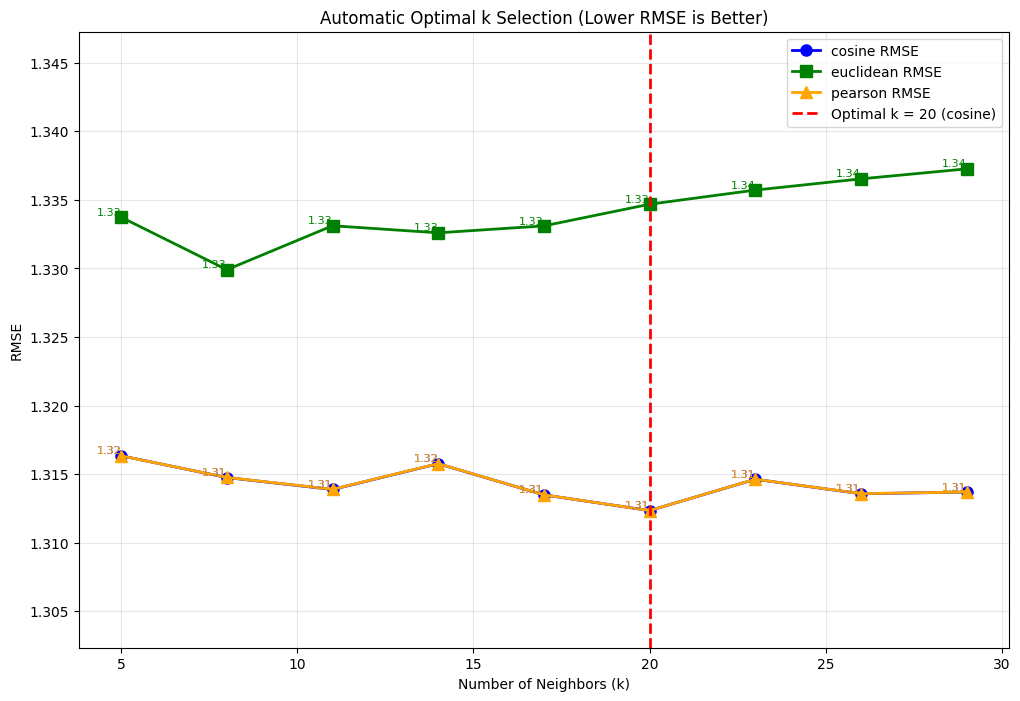

In [40]:
plot_optimal_k(results_df, best_result['k'], best_result['metric'])


In [ ]:
display(df[['k','metric','P@5','R@5','P@10','R@10','NDCG@10']])


In [51]:
recommendations, predicted = user_based_collaborative_filtering(
    user_game_matrix,
    target_user=list(user_game_matrix.index)[0],
    n_similar_users=int(best_result['k']),
    similarity_metric=best_result['metric']
)

print(f"\n🎮 Recommended games for {list(user_game_matrix.index)[0]}")
for g, s in recommendations:
    print(f"{g:40s}  predicted rating = {s:.2f}")


🎮 Recommended games for 5250
Prison Architect                          predicted rating = 0.18
Never Alone (Kisima Ingitchuna)           predicted rating = 0.12
Terraria                                  predicted rating = 0.09
Project Zomboid                           predicted rating = 0.09
Sid Meier's Civilization V                predicted rating = 0.08
Garry's Mod                               predicted rating = 0.06
Euro Truck Simulator 2                    predicted rating = 0.05
Software Inc.                             predicted rating = 0.04
Don't Starve                              predicted rating = 0.03
Half-Life 2                               predicted rating = 0.02
